# Fourier Neural Operator (FNO) — Burgers (GPU-only)

This notebook contains:
- FNO model definition (1D)
- Utilities (reader, normalizers, LpLoss)
- Training loop
- Evaluation block with metrics (rel-L2, MSE, MAE, RMSE, R²)
- Visualization examples and saving predictions/metrics to `.mat`

In [2]:
# Setup: imports and seeds
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from timeit import default_timer
from functools import reduce
import operator
import os
from utilities import EarlyStopping

import matplotlib.pyplot as plt
from IPython.display import clear_output
# seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())


Torch version: 2.7.1+cu126
CUDA available: True


In [3]:
# === utilities.py content (embedded) ===
import h5py
import scipy.io
import torch
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MatReader(object):
    def __init__(self, file_path, to_torch=True, to_cuda=False, to_float=True):
        super(MatReader, self).__init__()
        self.to_torch = to_torch
        self.to_cuda = to_cuda
        self.to_float = to_float
        self.file_path = file_path
        self.data = None
        self.old_mat = None
        self._load_file()

    def _load_file(self):
        try:
            self.data = scipy.io.loadmat(self.file_path)
            self.old_mat = True
        except:
            self.data = h5py.File(self.file_path)
            self.old_mat = False

    def load_file(self, file_path):
        self.file_path = file_path
        self._load_file()

    def read_field(self, field):
        x = self.data[field]
        if not self.old_mat:
            x = x[()]
            x = np.transpose(x, axes=range(len(x.shape) - 1, -1, -1))
        if self.to_float:
            x = x.astype(np.float32)
        if self.to_torch:
            x = torch.from_numpy(x)
            if self.to_cuda:
                x = x.cuda()
        return x

class UnitGaussianNormalizer(object):
    def __init__(self, x, eps=0.00001):
        self.mean = torch.mean(x, 0)
        self.std = torch.std(x, 0)
        self.eps = eps

    def encode(self, x):
        return (x - self.mean) / (self.std + self.eps)

    def decode(self, x, sample_idx=None):
        if sample_idx is None:
            std = self.std + self.eps
            mean = self.mean
        else:
            if len(self.mean.shape) == len(sample_idx[0].shape):
                std = self.std[sample_idx] + self.eps
                mean = self.mean[sample_idx]
            if len(self.mean.shape) > len(sample_idx[0].shape):
                std = self.std[:,sample_idx]+ self.eps
                mean = self.mean[:,sample_idx]
        x = (x * std) + mean
        return x

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()
    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()

# class LpLoss(object):
#     def __init__(self, d=2, p=2, size_average=True, reduction=True):
#         self.d = d
#         self.p = p
#         self.reduction = reduction
#         self.size_average = size_average

#     def abs(self, x, y):
#         num_examples = x.size()[0]
#         h = 1.0 / (x.size()[1] - 1.0)
#         all_norms = (h**(self.d/self.p))*torch.norm(x.view(num_examples,-1) - y.view(num_examples,-1), self.p, 1)
#         if self.reduction:
#             if self.size_average:
#                 return torch.mean(all_norms)
#             else:
#                 return torch.sum(all_norms)
#         return all_norms

#     def rel(self, x, y):
#         num_examples = x.size()[0]
#         diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
#         y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)
#         if self.reduction:
#             if self.size_average:
#                 return torch.mean(diff_norms/y_norms)
#             else:
#                 return torch.sum(diff_norms/y_norms)
#         return diff_norms/y_norms

#     def __call__(self, x, y):
#         return self.rel(x, y)


In [4]:
# === FNO model code (1D) ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from functools import reduce
import operator

def compl_mul(a, b):
    return torch.einsum("bix,iox->box", a, b)

class SpectralConv(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.scale = (1 / (in_channels * out_channels))
        # complex-valued weights
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    def forward(self, x):
        batchsize = x.shape[0]
        x_ft = torch.fft.rfft(x, dim=-1, norm='ortho')
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1] = compl_mul(x_ft[:, :, :self.modes1], self.weights1)
        x = torch.fft.irfft(out_ft, n=x.size(-1), dim=-1, norm='ortho')
        return x

class SimpleBlock1d(nn.Module):
    def __init__(self, modes, width):
        super(SimpleBlock1d, self).__init__()
        self.modes1 = modes
        self.width = width
        self.fc0 = nn.Linear(2, self.width)
        self.conv0 = SpectralConv(self.width, self.width, self.modes1)
        self.conv1 = SpectralConv(self.width, self.width, self.modes1)
        self.conv2 = SpectralConv(self.width, self.width, self.modes1)
        self.conv3 = SpectralConv(self.width, self.width, self.modes1)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)
        self.bn0 = torch.nn.BatchNorm1d(self.width)
        self.bn1 = torch.nn.BatchNorm1d(self.width)
        self.bn2 = torch.nn.BatchNorm1d(self.width)
        self.bn3 = torch.nn.BatchNorm1d(self.width)
        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.fc0(x)
        x = x.permute(0, 2, 1)
        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = self.bn0(x1 + x2)
        x = F.relu(x)
        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = self.bn1(x1 + x2)
        x = F.relu(x)
        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = self.bn2(x1 + x2)
        x = F.relu(x)
        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = self.bn3(x1 + x2)
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

class Net1d(nn.Module):
    def __init__(self, modes, width):
        super(Net1d, self).__init__()
        self.conv1 = SimpleBlock1d(modes, width)

    def forward(self, x):
        x = self.conv1(x)
        return x.squeeze()

    def count_params(self):
        c = 0
        for p in self.parameters():
            c += reduce(operator.mul, list(p.size()))
        return c


Configs

In [ ]:
sub = 8
h = 2**10 // sub
s = h
batch_size = 128
learning_rate = 0.00001
epochs = 500
step_size = 100
gamma = 0.5
modes = 16
width = 64

# path to your .mat (adjust if needed)
mat_path = 'data/burgers_data_R10.mat'

dataloader = MatReader(mat_path)
x_data = dataloader.read_field('a')[:,::sub]
y_data = dataloader.read_field('u')[:,::sub]
total_sampels = x_data.shape[0]
ntrain = int(0.8 * total_sampels)
ntest = total_sampels - ntrain
nval=int(0.1 * ntrain)
ntrain=ntrain - nval

# prepare train/test splits
x_train = x_data[:ntrain, ::sub]
y_train = y_data[:ntrain, ::sub]
x_val= x_data[ntrain:ntrain+nval, ::sub]
y_val= y_data[ntrain:ntrain+nval, ::sub]
x_test = x_data[-ntest:, ::sub]
y_test = y_data[-ntest:, ::sub]

grid = np.linspace(0, 2*np.pi, s).reshape(1, s, 1)
grid = torch.tensor(grid, dtype=torch.float)
x_train = torch.cat([x_train.reshape(ntrain,s,1), grid.repeat(ntrain,1,1)], dim=2)
x_val = torch.cat([x_val.reshape(nval,s,1), grid.repeat(nval,1,1)], dim=2)
x_test = torch.cat([x_test.reshape(ntest,s,1), grid.repeat(ntest,1,1)], dim=2)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_val, y_val), batch_size=batch_size, shuffle=False)

## Training 

In [6]:
os.makedirs('models/fno', exist_ok=True)

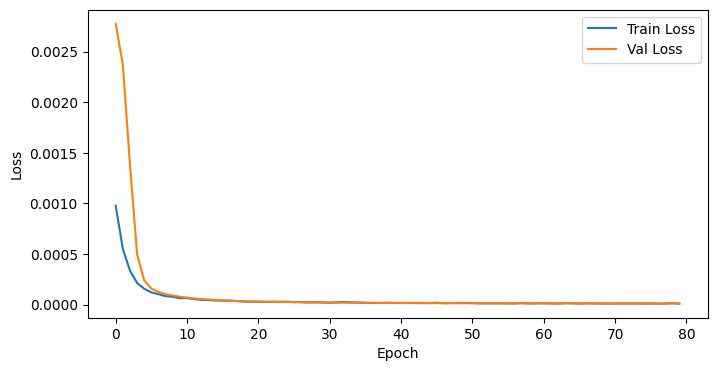

Epoch 079 | time 0.168s | train_mse 8.888011e-06 | val_mse: 1.032333e-05
EarlyStopping counter: 5 out of 5
We are at epoch: 80


In [ ]:
# create model on GPU
model = Net1d(modes, width).cuda()
print("Params:", model.count_params())
mse = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
early_stopping = EarlyStopping(patience=5, verbose=True, path='models/fno1d/fno1d_checkpoint.pt', trace_func=print)

train_losses=[]
val_losses=[]
for ep in range(epochs):
    model.train()
    
    t1 = default_timer()
    
    train_mse = 0.0
    val_mse = 0.0
    
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        out = model(x)
        # mse = F.mse_loss(out, y, reduction='mean')
        mse_val = mse(out.view(batch_size, -1), y.view(batch_size, -1))
        mse_val.backward()
        train_mse += mse_val.item()
        optimizer.step()
    
    # evaluation on test set (epoch)
    model.eval()
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.cuda(), y.cuda()
            out = model(x)
            mse_val = mse(out.view(batch_size, -1), y.view(batch_size, -1))
            val_mse += mse_val.item()
    train_mse /= ntrain
    val_mse /= nval
    train_losses.append(train_mse)
    val_losses.append(val_mse)
    t2 = default_timer()
    scheduler.step()

    # early stopping
    early_stopping(val_loss=val_mse,model=model)
    if early_stopping.early_stop:
        print("We are at epoch:", ep)
        break
    # Plotting
    clear_output(wait=True)
    plt.figure(figsize=(8,4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    print(f"Epoch {ep:03d} | time {t2-t1:.3f}s | train_mse {train_mse:.6e} | val_mse: {val_mse:.6e}")

## Evaluation & Metrics

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import os


# Ensure eval mode
model.eval()
preds = []
gts = []
rel_l2_list = []
mse_list = []
mae_list = []
rmse_list = []
r2_list = []

with torch.no_grad():
    for idx, (x, y) in enumerate(zip(x_test, y_test)):
        x= x.unsqueeze(0).cuda()
        out = model(x).cpu() 
        gts.append(y.numpy())
        preds.append(out.numpy())
        mse = mean_squared_error(y.flatten(), out.flatten())
        mae = mean_absolute_error(y.flatten(), out.flatten())
        rmse = np.sqrt(mse)
        r2 = r2_score(y.flatten(), out.flatten())

        mse_list.append(mse)
        mae_list.append(mae)
        rmse_list.append(rmse)
        r2_list.append(r2)

        print(f"Sample {idx:3d} | MSE: {mse:.6e} | RMSE: {rmse:.6e} | MAE: {mae:.6e} | R2: {r2:.4f}")


# summary
def summarize(metric_list, name):
    arr = np.array(metric_list)
    print(f"{name:10s} => mean: {np.mean(arr):.6e}    std: {np.std(arr):.6e}    median: {np.median(arr):.6e}")

print("\\n=== Summary over test set ===")
summarize(rel_l2_list, "rel-L2")
summarize(mse_list,   "MSE")
summarize(rmse_list,  "RMSE")
summarize(mae_list,   "MAE")
summarize(r2_list,    "R2")

Sample   0 | MSE: 1.580026e-04 | RMSE: 1.256991e-02 | MAE: 9.241749e-03 | R2: 0.9975
Sample   1 | MSE: 2.373598e-04 | RMSE: 1.540649e-02 | MAE: 1.246308e-02 | R2: 0.9951
Sample   2 | MSE: 4.321935e-04 | RMSE: 2.078926e-02 | MAE: 1.605285e-02 | R2: 0.9987
Sample   3 | MSE: 1.872215e-04 | RMSE: 1.368289e-02 | MAE: 1.126818e-02 | R2: 0.9954
Sample   4 | MSE: 1.133288e-04 | RMSE: 1.064560e-02 | MAE: 8.209275e-03 | R2: 0.9980
Sample   5 | MSE: 1.915621e-04 | RMSE: 1.384060e-02 | MAE: 1.069066e-02 | R2: 0.9978
Sample   6 | MSE: 2.306965e-04 | RMSE: 1.518870e-02 | MAE: 1.173759e-02 | R2: 0.9979
Sample   7 | MSE: 3.313125e-04 | RMSE: 1.820199e-02 | MAE: 1.418989e-02 | R2: 0.9969
Sample   8 | MSE: 6.620881e-03 | RMSE: 8.136880e-02 | MAE: 5.482706e-02 | R2: 0.9919
Sample   9 | MSE: 3.277798e-04 | RMSE: 1.810469e-02 | MAE: 1.414244e-02 | R2: 0.9981
Sample  10 | MSE: 3.405131e-04 | RMSE: 1.845300e-02 | MAE: 1.473245e-02 | R2: 0.9986
Sample  11 | MSE: 5.966905e-04 | RMSE: 2.442725e-02 | MAE: 1.9450

/home/rusted/anaconda3/envs/neuralop/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/rusted/anaconda3/envs/neuralop/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/rusted/anaconda3/envs/neuralop/lib/python3.13/site-packages/numpy/_core/_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/rusted/anaconda3/envs/neuralop/lib/python3.13/site-packages/numpy/_core/_methods.py:180: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/rusted/anaconda3/envs/neuralop/lib/python3.13/site-packages/numpy/_core/_methods.py:214: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
results={
    'mse':np.mean(mse_list),
    'rmse':np.mean(rmse_list),
    'mae':np.mean(mae_list),
    'r2':np.mean(r2_list),
    'pred': np.array(preds), 'gts':np.array(gts),
    'rel_l2_list': np.array(rel_l2_list),
    'mse_list': np.array(mse_list),
    'mae_list': np.array(mae_list),
    'rmse_list': np.array(rmse_list),
    'r2_list': np.array(r2_list)
}
import pickle
pickle.dump(results, open('models/fno1d/burger_test_metrics.pickle', 'wb'))

## Plot example predictions

In [ ]:
results=pickle.load(open('models/fno1d/burger_test_metrics.pickle', 'rb'))

In [11]:
preds=results['pred']
gts=results['gts']

In [12]:
gts.shape,preds.shape

((410, 128), (410, 128))

Plot example test samples (first, median, last)

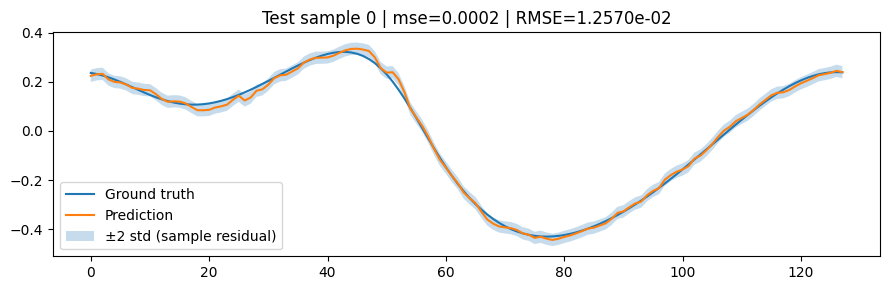

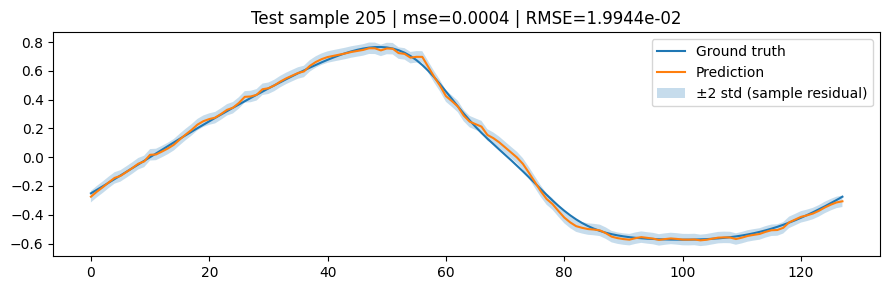

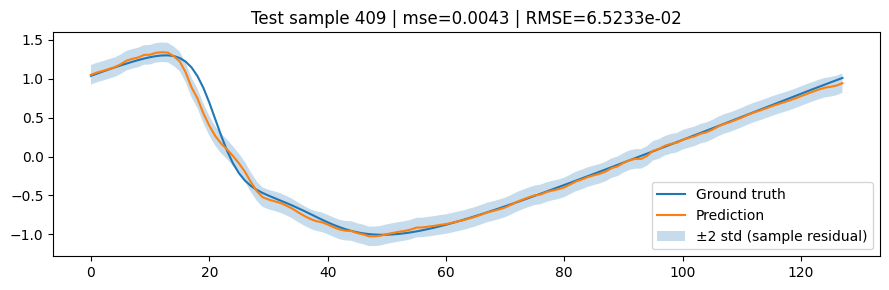

In [ ]:
example_idxs = [0, len(preds)//2, len(preds)-1]
x_axis = np.arange(preds.shape[1])

for ex in example_idxs:
    plt.figure(figsize=(9,3))
    plt.plot(x_axis, gts[ex], label='Ground truth')
    plt.plot(x_axis, preds[ex], label='Prediction')
    resid = preds[ex].flatten() - gts[ex].flatten()
    plt.fill_between(x_axis,
                     preds[ex].flatten() - 2*np.std(resid),
                     preds[ex].flatten() + 2*np.std(resid),
                     alpha=0.25, label='±2 std (sample residual)')
    plt.title(f"Test sample {ex} | mse={mse_list[ex]:.4f} | RMSE={rmse_list[ex]:.4e}")
    plt.legend()
    plt.tight_layout()
    plt.show()